1. Повнозв'язані нейронні мережі

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
import os
import re
import string
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("BMW sales data (2010-2024) (1).csv") 
print(df.shape)
df.head()

(50000, 11)


,Model,Year,Region,Color,Fuel_Type,Transmission,Engine_Size_L,Mileage_KM,Price_USD,Sales_Volume,Sales_Classification
0,5 Series,2016,Asia,Red,Petrol,Manual,3.5,151748,98740,8300,High
1,i8,2013,North America,Red,Hybrid,Automatic,1.6,121671,79219,3428,Low
2,5 Series,2022,North America,Blue,Petrol,Automatic,4.5,10991,113265,6994,Low
3,X3,2024,Middle East,Blue,Petrol,Automatic,1.7,27255,60971,4047,Low
4,7 Series,2020,South America,Black,Diesel,Manual,2.1,122131,49898,3080,Low


In [3]:
#LabelEncoder
df_encoded = pd.get_dummies(df, columns=['Model', 'Region', 'Color', 'Fuel_Type', 'Transmission'], drop_first=True)
le = LabelEncoder()
df_encoded['Sales_Classification'] = le.fit_transform(df_encoded['Sales_Classification'])

In [4]:
#поділ на тестову і трейнову вибірки
X = df_encoded.drop('Sales_Classification', axis=1).astype(float)
y = df_encoded['Sales_Classification']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
#scaler
scaler = StandardScaler()
numerical_cols = ['Year', 'Engine_Size_L', 'Mileage_KM', 'Price_USD', 'Sales_Volume']
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

In [6]:
#pytorch
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [7]:
#нейронка
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [8]:
#навчання
model = MLP(X_train.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(50):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

In [9]:
#test
model.eval()
y_pred = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.numpy())

print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy: 0.9943
              precision    recall  f1-score   support

        High       0.99      0.99      0.99      3032
         Low       1.00      1.00      1.00      6968

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



2. Згорткові нейронні мережі

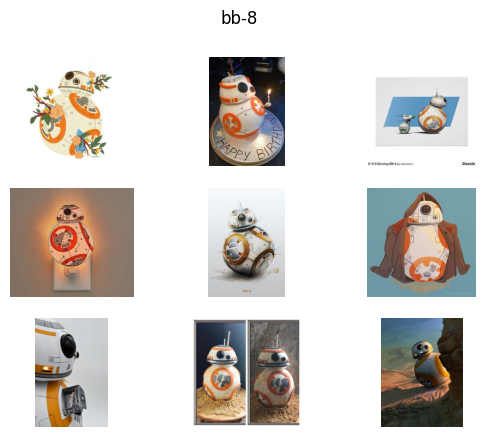

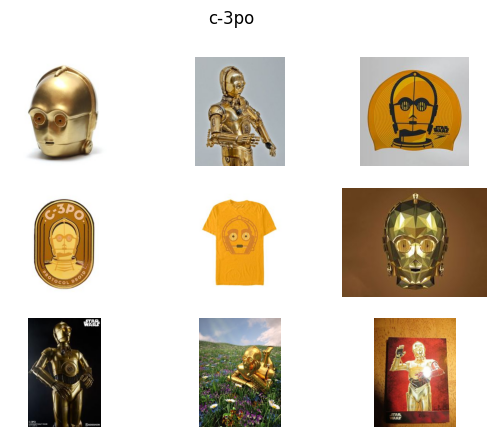

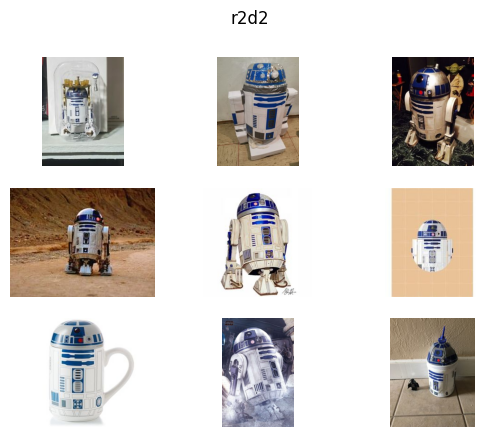

In [10]:
path = 'star-wars-images/star_wars/filtered/train/' 
categories = ['bb-8', 'c-3po', 'r2d2']
num_classes = 3

for category in categories:
    fig, axs = plt.subplots(3, 3)
    fig.suptitle(category)
    for n, f_name in enumerate(os.listdir(path + category)[:9]):
        img = plt.imread(path + category + '/' + f_name)
        axs[n // 3, n % 3].imshow(img)
        axs[n // 3, n % 3].axis('off')
    plt.show()

In [11]:
x, y = [], []
import cv2
#preprocessing
for n, category in enumerate(categories):
    for f in os.listdir(path + category):
        image_path = path + category + '/' + f
        image = cv2.imread(image_path)
        try:
          image = cv2.resize(image, (30, 50))
          image = image / 255.0
          x.append(image)
          y.append(n)
        except:
          pass

#поділ на тестову і трейнову вибірки
x_train, x_test, y_train, y_test = train_test_split(np.array(x), np.array(y), test_size=0.2)

y_train = keras.utils.to_categorical(y_train, 3)
y_test = keras.utils.to_categorical(y_test, 3)

print('x_train shape:', x_train.shape)
print('train number:', x_train.shape[0])
print('test number:', x_test.shape[0])

x_train shape: (588, 50, 30, 3)
train number: 588
test number: 147


In [12]:
#модель
model = keras.Sequential()
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(50, 30, 3)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 48, 28, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 22, 12, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 11, 6, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4224)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4224)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │          12,675 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,067 (125.26 KB)

 Trainable params: 32,067 (125.26 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
#train
history = model.fit(x_train, y_train, batch_size=32, epochs=20)

Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.3503 - loss: 1.1071
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5663 - loss: 0.9583
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6429 - loss: 0.7774
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7364 - loss: 0.6708
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7806 - loss: 0.5767
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7891 - loss: 0.5201
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8078 - loss: 0.4842
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8350 - loss: 0.4356
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8435 - loss: 0.4052
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8452 - loss: 0.4105
Epoch 11/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8622 - loss: 0.3655
Epoch 12/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy:

In [14]:
#score
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.3069230020046234
Test accuracy: 0.9115646481513977


3. Рекурентні нейронні мережі

In [15]:
#поділ на тестову і трейнову вибірки
df = pd.read_csv('spambase/spambase.data', header=None)
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values 

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train = X_train.astype(np.float32)
X_val   = X_val.astype(np.float32)
y_train = y_train.astype(np.int64)
y_val   = y_val.astype(np.int64)

In [16]:
class SpamDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

BATCH_SIZE = 64

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_dataset = SpamDataset(X_train, y_train)
val_dataset = SpamDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

fasttext_path = "wiki-news-300d-1M.vec"
embedding_matrix = np.zeros((57, 300), dtype='float32')

with open(fasttext_path, encoding='utf-8') as f:
    next(f)
    for i, line in enumerate(f):
        if i >= 57:
            break
        values = line.rstrip().split(' ')
        embedding_matrix[i] = np.asarray(values[1:], dtype='float32')

embedding_matrix = torch.tensor(embedding_matrix)

In [18]:
#LSTM
class LSTMModel(nn.Module):
    def __init__(self, pretrained_matrix=None, freeze=False):
        super().__init__()
        if pretrained_matrix is None:
            self.embedding = nn.Embedding(57, 300)
        else:
            self.embedding = nn.Embedding.from_pretrained(pretrained_matrix, freeze=freeze)

        self.lstm = nn.LSTM(300, 128, bidirectional=True, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(256, 1)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        idx = torch.arange(57, device=x.device).unsqueeze(0).repeat(x.size(0), 1)
        emb = self.embedding(idx)
        emb = emb * x.unsqueeze(2)
        out, (h, c) = self.lstm(emb)
        h = torch.cat((h[-2], h[-1]), dim=1)
        return self.fc(self.dropout(h)).squeeze(1)

model_random = LSTMModel(pretrained_matrix=None).to(device)
opt_random = optim.Adam(model_random.parameters(), lr=0.001)

#FastText
model_pretrained = LSTMModel(pretrained_matrix=embedding_matrix, freeze=False).to(device)
opt_pretrained = optim.Adam(model_pretrained.parameters(), lr=0.0005)

In [20]:
criterion = nn.BCEWithLogitsLoss()
#train
def train(model, opt, name, epochs=15):
    print(f"\n{name}")
    best = 0
    for epoch in range(1, epochs+1):
        model.train()
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            opt.zero_grad()
            loss = criterion(model(Xb), yb.float())
            loss.backward()
            opt.step()
        #test
        model.eval()
        with torch.no_grad():
            pred = (torch.sigmoid(model(torch.tensor(X_val).to(device))) > 0.5).cpu().numpy()
            acc = accuracy_score(y_val, pred)
            if acc > best:
                best = acc
        print(f"Епоха {epoch:2d} → Acc: {acc:.4f}")
    print(f"Найкраща точність: {best:.1%}\n")

train(model_random, opt_random, "а) Випадковий Embedding")
train(model_pretrained, opt_pretrained, "б) Pre-trained FastText")


а) Випадковий Embedding
Епоха  1 → Acc: 0.9240
Епоха  2 → Acc: 0.9262
Епоха  3 → Acc: 0.9283
Епоха  4 → Acc: 0.9294
Епоха  5 → Acc: 0.9338
Епоха  6 → Acc: 0.9283
Епоха  7 → Acc: 0.9294
Епоха  8 → Acc: 0.9294
Епоха  9 → Acc: 0.9229
Епоха 10 → Acc: 0.9218
Епоха 11 → Acc: 0.9240
Епоха 12 → Acc: 0.9218
Епоха 13 → Acc: 0.9186
Епоха 14 → Acc: 0.9251
Епоха 15 → Acc: 0.9251
Найкраща точність: 93.4%


б) Pre-trained FastText
Епоха  1 → Acc: 0.9273
Епоха  2 → Acc: 0.9240
Епоха  3 → Acc: 0.9305
Епоха  4 → Acc: 0.9197
Епоха  5 → Acc: 0.9273
Епоха  6 → Acc: 0.9338
Епоха  7 → Acc: 0.9370
Епоха  8 → Acc: 0.9349
Епоха  9 → Acc: 0.9316
Епоха 10 → Acc: 0.9349
Епоха 11 → Acc: 0.9370
Епоха 12 → Acc: 0.9370
Епоха 13 → Acc: 0.9327
Епоха 14 → Acc: 0.9359
Епоха 15 → Acc: 0.9370
Найкраща точність: 93.7%

